<a href="https://colab.research.google.com/github/Kanwar5714/NNSmith/blob/main/code_coverage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytest pytest-cov coverage


In [ ]:
# Install the required packages
!pip install pytest pytest-cov coverage

# Write the test cases to a file (test_compiler.py)
test_code = """
import pytest
from nnsmith.abstract.arith import nnsmith_lt
from nnsmith.abstract.extension import activate_ext, patch_requires
from nnsmith.abstract.op import Constant, Input, NCHWConv2d, ReLU
from nnsmith.graph_gen import model_gen

def test_only_conv_relu():
    gen = model_gen(
        opset=[ReLU, NCHWConv2d],
        max_nodes=5,
        rank_choices=(4,),
        dtype_choices=("float32",),
    )
    ir = gen.make_concrete()
    for inst in ir.insts:
        assert type(inst.iexpr.op) in [ReLU, Input, Constant, NCHWConv2d]

def test_constrain_conv_ksize():
    @patch_requires("global", "core.NCHWConv2d")
    def limit_conv2d(self, _):
        # let the kernels to be > 3
        return [nnsmith_lt(3, self.kernel_h_size), nnsmith_lt(3, self.kernel_w_size)]

    opset = [ReLU, NCHWConv2d]
    activate_ext(opset)
    gen = model_gen(
        opset=opset,
        max_nodes=5,
        rank_choices=(4,),
        dtype_choices=("float32",),
    )

    ir = gen.make_concrete()
    for inst in ir.insts:
        assert type(inst.iexpr.op) in [ReLU, Input, Constant, NCHWConv2d]
        if isinstance(inst.iexpr.op, NCHWConv2d):
            assert inst.iexpr.op.kernel_h_size > 3
            assert inst.iexpr.op.kernel_w_size > 3
"""

with open("test_compiler.py", "w") as f:
    f.write(test_code)

# Run tests with coverage
!pytest --cov=nnsmith --cov-report=term-missing test_compiler.py


======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.4, pluggy-1.5.0
rootdir: /content
plugins: cov-5.0.0, anyio-3.7.1
collected 0 items / 1 error                                                                        
/usr/local/lib/python3.10/dist-packages/coverage/inorout.py:503: CoverageWarning: Module nnsmith was never imported. (module-not-imported)
  self.warn(f"Module {pkg} was never imported.", slug="module-not-imported")
/usr/local/lib/python3.10/dist-packages/coverage/control.py:888: CoverageWarning: No data was collected. (no-data-collected)
  self._warn("No data was collected.", slug="no-data-collected")

/usr/local/lib/python3.10/dist-packages/pytest_cov/plugin.py:352: CovReportWarning: Failed to generate report: No data to report.

  warnings.warn(CovReportWarning(message), stacklevel=1)

============================================== ERRORS ======================================

In [ ]:
!pip install nnsmith


In [ ]:
import sys
print(sys.path)


['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
import pytest
from nnsmith.abstract.arith import nnsmith_lt
from nnsmith.abstract.extension import activate_ext, patch_requires
from nnsmith.abstract.op import Constant, Input, NCHWConv2d, ReLU
from nnsmith.graph_gen import model_gen

def test_different_opset_combinations():
    # Test with different combinations of operators in the opset
    opset_combinations = [
        [ReLU, NCHWConv2d],
        [Input, Constant],
        [ReLU, Input, Constant],
        # Add more combinations as needed
    ]

    for opset in opset_combinations:
        gen = model_gen(
            opset=opset,
            max_nodes=5,
            rank_choices=(4,),
            dtype_choices=("float32",),
        )

        ir = gen.make_concrete()

        for inst in ir.insts:
            assert type(inst.iexpr.op) in opset


def test_maximum_nodes_limit():
    # Test with different maximum nodes limits
    max_nodes_values = [3, 5, 10]

    for max_nodes in max_nodes_values:
        gen = model_gen(
            opset=[ReLU, NCHWConv2d],
            max_nodes=max_nodes,
            rank_choices=(4,),
            dtype_choices=("float32",),
        )

        ir = gen.make_concrete()

        assert len(ir.insts) <= max_nodes


def test_different_rank_choices():
    # Test with different choices of ranks
    rank_choices_values = [(4,), (3, 4), (2, 3, 4)]

    for rank_choices in rank_choices_values:
        gen = model_gen(
            opset=[ReLU, NCHWConv2d],
            max_nodes=5,
            rank_choices=rank_choices,
            dtype_choices=("float32",),
        )

        ir = gen.make_concrete()

        assert len(ir.insts) > 0  # Ensure at least one instance is generated


def test_different_dtype_choices():
    # Test with different data type choices
    dtype_choices_values = [("float32",), ("int32",), ("float32", "int32")]

    for dtype_choices in dtype_choices_values:
        gen = model_gen(
            opset=[ReLU, NCHWConv2d],
            max_nodes=5,
            rank_choices=(4,),
            dtype_choices=dtype_choices,
        )

        ir = gen.make_concrete()

        assert len(ir.insts) > 0  # Ensure at least one instance is generated


def test_patching_requirements():
    # Test patching requirements for different operator combinations
    opset_combinations = [
        ([ReLU, NCHWConv2d],),
        ([Input, Constant],),
        ([ReLU, Input, Constant],),
        # Add more combinations as needed
    ]

    for opset in opset_combinations:
        @patch_requires("global", "core.NCHWConv2d")
        def limit_conv2d(self, _):
            # let the kernels to be > 3
            return [nnsmith_lt(3, self.kernel_h_size), nnsmith_lt(3, self.kernel_w_size)]

        activate_ext(opset)
        gen = model_gen(
            opset=opset,
            max_nodes=5,
            rank_choices=(4,),
            dtype_choices=("float32",),
        )

        ir = gen.make_concrete()

        for inst in ir.insts:
            assert type(inst.iexpr.op) in opset
            if isinstance(inst.iexpr.op, NCHWConv2d):
                assert inst.iexpr.op.kernel_h_size > 3
                assert inst.iexpr.op.kernel_w_size > 3


/usr/local/lib/python3.10/dist-packages/nnsmith/util.py:20: UserWarning: Install pygraphviz for visualization: https://pygraphviz.github.io/documentation/stable/install.html
Currently graph visualization is not enabled.
  warnings.warn(


In [ ]:
import pytest
from nnsmith.abstract.arith import nnsmith_lt
from nnsmith.abstract.extension import activate_ext, patch_requires
from nnsmith.abstract.op import Constant, Input, NCHWConv2d, ReLU
from nnsmith.graph_gen import model_gen

def test_generate_graph_with_user_input():
    # Test generating a graph with user input for opset, max_nodes, rank_choices, and dtype_choices
    user_opset = [ReLU, NCHWConv2d]
    user_max_nodes = 5
    user_rank_choices = (4,)
    user_dtype_choices = ("float32",)

    gen = model_gen(
        opset=user_opset,
        max_nodes=user_max_nodes,
        rank_choices=user_rank_choices,
        dtype_choices=user_dtype_choices,
    )

    ir = gen.make_concrete()

    # Assert that the generated graph meets user specifications
    assert len(ir.insts) > 0  # Ensure at least one instance is generated
    for inst in ir.insts:
        assert type(inst.iexpr.op) in user_opset


In [ ]:
import pytest

from nnsmith.abstract.arith import nnsmith_lt
from nnsmith.abstract.extension import activate_ext, patch_requires
from nnsmith.abstract.op import Constant, Input, NCHWConv2d, ReLU
from nnsmith.graph_gen import model_gen


def test_only_conv_relu():
    gen = model_gen(
        opset=[ReLU, NCHWConv2d],
        max_nodes=5,
        rank_choices=(4,),
        dtype_choices=("float32",),
    )

    ir = gen.make_concrete()

    for inst in ir.insts:
        assert type(inst.iexpr.op) in [ReLU, Input, Constant, NCHWConv2d]


def test_constrain_conv_ksize():
    @patch_requires("global", "core.NCHWConv2d")
    def limit_conv2d(self, _):
        # let the kernels to be > 3
        return [nnsmith_lt(3, self.kernel_h_size), nnsmith_lt(3, self.kernel_w_size)]

    opset = [ReLU, NCHWConv2d]
    activate_ext(opset)
    gen = model_gen(
        opset=opset,
        max_nodes=5,
        rank_choices=(4,),
        dtype_choices=("float32",),
    )

    ir = gen.make_concrete()
    for inst in ir.insts:
        assert type(inst.iexpr.op) in [ReLU, Input, Constant, NCHWConv2d]
        if isinstance(inst.iexpr.op, NCHWConv2d):
            assert inst.iexpr.op.kernel_h_size > 3
            assert inst.iexpr.op.kernel_w_size > 3

Enter data points separated by commas (e.g., 1,2,3,4,5): 45, 56,67,56


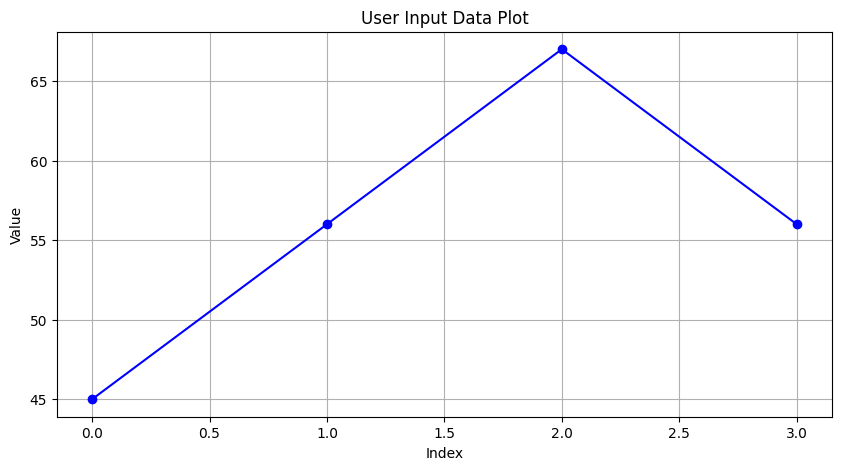

In [ ]:
import matplotlib.pyplot as plt

def get_user_input():
    # Prompt user for input
    user_input = input("Enter data points separated by commas (e.g., 1,2,3,4,5): ")
    # Split the input string into a list of strings
    data_str = user_input.split(',')
    # Convert the list of strings to a list of floats
    data = [float(x) for x in data_str]
    return data

def plot_data(data):
    # Generate x values
    x = range(len(data))
    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(x, data, marker='o', linestyle='-', color='b')
    plt.title('User Input Data Plot')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

def main():
    # Get data from the user
    data = get_user_input()
    # Plot the data
    plot_data(data)

# Run the main function
if __name__ == "__main__":
    main()


Enter the number of test cases: 4
Enter the accuracy for test case 1: 45
Enter the accuracy for test case 2: 56
Enter the accuracy for test case 3: 67
Enter the accuracy for test case 4: 34


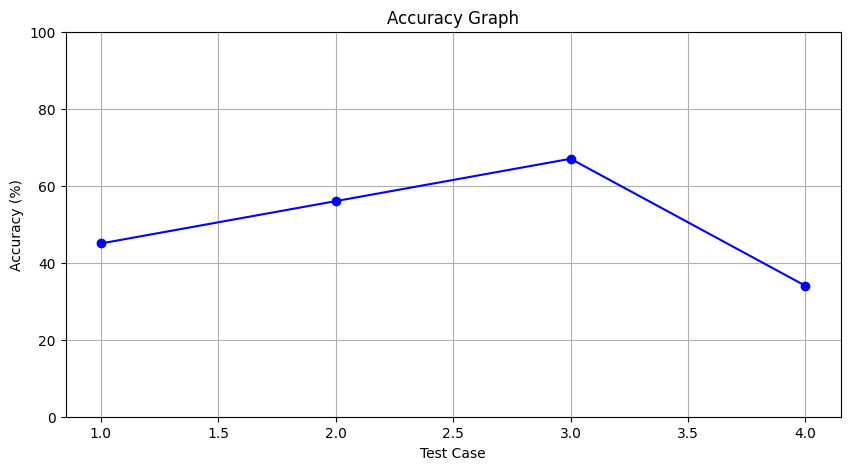

In [ ]:
import matplotlib.pyplot as plt

def get_user_input():
    # Prompt user for the number of test cases
    num_cases = int(input("Enter the number of test cases: "))
    accuracies = []
    for i in range(num_cases):
        accuracy = float(input(f"Enter the accuracy for test case {i + 1}: "))
        accuracies.append(accuracy)
    return accuracies

def plot_accuracy_graph(accuracies):
    # Generate x values
    x = range(1, len(accuracies) + 1)
    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(x, accuracies, marker='o', linestyle='-', color='b')
    plt.title('Accuracy Graph')
    plt.xlabel('Test Case')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.ylim(0, 100)  # Assuming accuracy is given as a percentage
    plt.show()

def main():
    # Get accuracy data from the user
    accuracies = get_user_input()
    # Plot the accuracy graph
    plot_accuracy_graph(accuracies)

# Run the main function
if __name__ == "__main__":
    main()



Enter the number of test cases to generate: 5
Test Case 1: Model: Reshape -> Add -> Conv2d -> Reshape - Coverage: 0.90
Test Case 2: Model: Add -> Reshape -> Conv2d -> Add -> Add - Coverage: 0.80
Test Case 3: Model: Reshape - Coverage: 0.72
Test Case 4: Model: Reshape - Coverage: 0.86
Test Case 5: Model: Reshape -> Add -> Conv2d - Coverage: 0.81


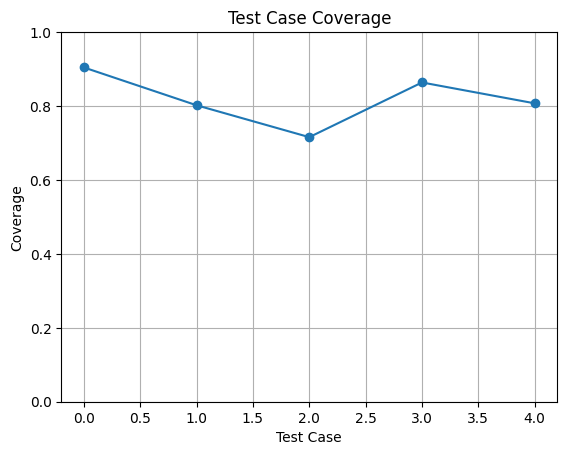

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define some mock tensor operators
class Operator:
    def __init__(self, name, input_shapes, output_shape):
        self.name = name
        self.input_shapes = input_shapes
        self.output_shape = output_shape

def generate_random_operator():
    operators = [
        Operator('Conv2d', [(1, 3, 64, 64)], (1, 2, 62, 62)),
        Operator('Add', [(1, 2, 62, 62), (1, 2, 62, 62)], (1, 2, 62, 62)),
        Operator('Reshape', [(1, 2, 62, 62)], (62, 62, 2)),
        # Add more operators as needed
    ]
    return random.choice(operators)

def generate_random_model():
    model = []
    num_layers = random.randint(1, 5)  # Generate a model with 1 to 5 layers
    for _ in range(num_layers):
        model.append(generate_random_operator())
    return model

def model_to_string(model):
    return " -> ".join([op.name for op in model])

# Mock function to simulate running the model and collecting coverage
def run_model(model):
    coverage = random.uniform(0.5, 1.0)  # Simulate coverage between 50% and 100%
    return coverage

# Generate test cases
def generate_test_cases(num_cases):
    test_cases = []
    for _ in range(num_cases):
        model = generate_random_model()
        coverage = run_model(model)
        test_cases.append((model, coverage))
    return test_cases

# Function to plot accuracy graph
def plot_coverage(test_cases):
    coverages = [coverage for _, coverage in test_cases]
    plt.plot(range(len(coverages)), coverages, marker='o')
    plt.title('Test Case Coverage')
    plt.xlabel('Test Case')
    plt.ylabel('Coverage')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

# Main function
def main():
    num_cases = int(input("Enter the number of test cases to generate: "))
    test_cases = generate_test_cases(num_cases)
    for i, (model, coverage) in enumerate(test_cases):
        print(f"Test Case {i+1}: Model: {model_to_string(model)} - Coverage: {coverage:.2f}")
    plot_coverage(test_cases)

if __name__ == "__main__":
    main()
